# Waste Classification Project using a complete CNN from scratch with a pipeline of Preprocessing and Image Enhancement => Segmentation => Feature Extraction => Classification => Evaluation and Performance Metrics.

In [ ]:
#pip install opencv-python numpy matplotlib scikit-learn pillow scikit-image
#pip install opencv-python-headless
#pip install opencv-contrib-python
#pip install opencv-contrib-python-headless
#pip install torch torchvision albumentations scikit-image scikit-learn matplotlib seaborn opencv-python

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import random
import time
import pickle
from skimage.feature import graycomatrix, graycoprops

IMAGE_SIZE = (128, 128)
NUM_CLASSES = 3
CLASS_NAMES = ['Boxes', 'Metal', 'Plastic']

## Loading Dataset

In [4]:
def load_dataset(dataset_dir="./dataset"):
    train_data = []
    train_labels = []
    
    try:
        with open(os.path.join(dataset_dir, "labels", "train.txt"), "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    img_path = parts[0]
                    if img_path.startswith("./dataset"):
                        img_path = img_path.replace("./dataset", dataset_dir)
                    label = int(parts[1])
                    
                    if os.path.exists(img_path):
                        train_data.append(img_path)
                        train_labels.append(label)
                    else:
                        print(f"Warning: File {img_path} not found")
    except Exception as e:
        print(f"Error loading training data: {e}")
        return ([], []), ([], [])
    
    test_data = []
    test_labels = []
    try:
        with open(os.path.join(dataset_dir, "labels", "test.txt"), "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 2:
                    img_path = parts[0]
                    if img_path.startswith("./dataset"):
                        img_path = img_path.replace("./dataset", dataset_dir)
                    label = int(parts[1])
                    
                    if os.path.exists(img_path):
                        test_data.append(img_path)
                        test_labels.append(label)
                    else:
                        print(f"Warning: File {img_path} not found")
    except Exception as e:
        print(f"Error loading test data: {e}")
        if not train_data:
            return ([], []), ([], [])
    
    print(f"Loaded {len(train_data)} training images and {len(test_data)} test images")
    return (train_data, train_labels), (test_data, test_labels)

def visualize_dataset_samples(data, labels, num_samples=2):
    if not data or not labels:
        print("No data to visualize")
        return
        
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        for class_id in range(NUM_CLASSES):
            indices = [idx for idx, label in enumerate(labels) if label == class_id]
            if indices:
                sample_idx = random.choice(indices)
                img_path = data[sample_idx]
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image at {img_path}")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    plt.subplot(num_samples, NUM_CLASSES, i*NUM_CLASSES + class_id + 1)
                    plt.imshow(img)
                    plt.title(f"{CLASS_NAMES[class_id]}")
                    plt.axis('off')
                except Exception as e:
                    print(f"Error visualizing {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

## PREPROCESSING AND IMAGE ENHANCEMENT

In [5]:
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        
        img_denoised = cv2.fastNlMeansDenoisingColored(img_resized, None, 10, 10, 7, 21)
        
        lab = cv2.cvtColor(img_denoised, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        img_normalized = img_enhanced.astype(np.float32) / 255.0
        
        return img_normalized, img
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        blank = np.zeros((*target_size, 3), dtype=np.float32)
        return blank, blank

def apply_augmentation(image):
    try:
        if random.random() > 0.5:
            image = cv2.flip(image, 1)
        
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
        image = cv2.warpAffine(image, M, (w, h))
        
        alpha = random.uniform(0.8, 1.2)
        beta = random.uniform(-10, 10)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        
        if random.random() > 0.7:
            image = cv2.GaussianBlur(image, (5, 5), 0)
        
        return image
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return image

def visualize_preprocessing(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image at {image_path}")
            return
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_resized = cv2.resize(img, IMAGE_SIZE)
        
        img_denoised = cv2.fastNlMeansDenoisingColored(img_resized, None, 10, 10, 7, 21)
        
        lab = cv2.cvtColor(img_denoised, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        img_normalized = img_enhanced.astype(np.float32) / 255.0
        
        img_augmented = apply_augmentation(img_enhanced)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(img_resized)
        plt.title('Resized')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(img_denoised)
        plt.title('Denoised')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(img_enhanced)
        plt.title('Enhanced Contrast')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(img_normalized)
        plt.title('Normalized')
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(img_augmented)
        plt.title('Augmented')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in visualizing preprocessing: {e}")

def preprocess_dataset(data_paths, labels, augment=True, num_augmentations=2):
    X = []
    y = []
    
    for i, (img_path, label) in enumerate(zip(data_paths, labels)):
        try:
            img_preprocessed, _ = preprocess_image(img_path)
            
            if np.all(img_preprocessed == 0):
                continue
                
            X.append(img_preprocessed)
            y.append(label)
            
            if augment:
                for _ in range(num_augmentations):
                    img_aug = apply_augmentation(img_preprocessed)
                    X.append(img_aug)
                    y.append(label)
                    
            if (i+1) % 50 == 0:
                print(f"Processed {i+1}/{len(data_paths)} images")
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    if X:
        X = np.array(X)
        y = np.array(y)
    else:
        print("Warning: No images were successfully processed!")
        X = np.array([])
        y = np.array([])
    
    return X, y

## Segmentation

In [6]:
def otsu_thresholding(image):
    try:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
        
        if gray.dtype == np.float32 or gray.dtype == np.float64:
            gray = (gray * 255).astype(np.uint8)
            
        if np.min(gray) < np.max(gray):
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            return binary
            
        binary = np.zeros_like(gray)
        return binary
    except Exception as e:
        print(f"Error in Otsu thresholding: {e}")
        if len(image.shape) == 3:
            return np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        else:
            return np.zeros_like(image, dtype=np.uint8)

def edge_based_segmentation(image):
    try:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
        
        if gray.dtype == np.float32 or gray.dtype == np.float64:
            gray = (gray * 255).astype(np.uint8)
        
        edges = cv2.Canny(gray, 50, 150)
        
        kernel = np.ones((3, 3), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
        
        return edges
    except Exception as e:
        print(f"Error in edge-based segmentation: {e}")
        if len(image.shape) == 3:
            return np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        else:
            return np.zeros_like(image, dtype=np.uint8)

def region_growing_segmentation(image, seed_points=None, threshold=10):
    try:
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
        
        if gray.dtype == np.float32 or gray.dtype == np.float64:
            gray = (gray * 255).astype(np.uint8)
        
        segmented = np.zeros_like(gray, dtype=np.uint8)
        
        if seed_points is None:
            h, w = gray.shape
            seed_points = []
            for _ in range(5):
                y = random.randint(0, h-1)
                x = random.randint(0, w-1)
                seed_points.append((y, x))
        
        for seed_y, seed_x in seed_points:
            if seed_y < 0 or seed_y >= gray.shape[0] or seed_x < 0 or seed_x >= gray.shape[1]:
                continue
            
            region = [(seed_y, seed_x)]
            processed = np.zeros_like(gray, dtype=bool)
            processed[seed_y, seed_x] = True
            
            seed_intensity = int(gray[seed_y, seed_x])
            
            max_region_size = 10000
            region_count = 0
            
            while region and region_count < max_region_size:
                y, x = region.pop(0)
                segmented[y, x] = 255
                region_count += 1
                
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    
                    if 0 <= ny < gray.shape[0] and 0 <= nx < gray.shape[1]:
                        if not processed[ny, nx]:
                            if abs(int(gray[ny, nx]) - seed_intensity) <= threshold:
                                region.append((ny, nx))
                                processed[ny, nx] = True
        
        return segmented
    except Exception as e:
        print(f"Error in region growing segmentation: {e}")
        if len(image.shape) == 3:
            return np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        else:
            return np.zeros_like(image, dtype=np.uint8)

def k_means_segmentation(image, k=3, max_iterations=50):
    try:
        if len(image.shape) == 3:
            pixel_values = image.reshape((-1, 3))
            pixel_values = np.float32(pixel_values)
            
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iterations, 1.0)
            
            _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            
            centers = np.uint8(centers)
            segmented_flat = centers[labels.flatten()]
            segmented = segmented_flat.reshape(image.shape)
            
            labels_2d = labels.reshape(image.shape[:2])
            
            return segmented, labels_2d
        else:
            pixel_values = image.reshape((-1, 1))
            pixel_values = np.float32(pixel_values)
            
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iterations, 1.0)
            
            _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            
            centers = np.uint8(centers)
            segmented_flat = centers[labels.flatten()]
            segmented = segmented_flat.reshape(image.shape)
            
            labels_2d = labels.reshape(image.shape)
            
            return segmented, labels_2d
    except Exception as e:
        print(f"Error in k-means segmentation: {e}")
        if len(image.shape) == 3:
            if image.dtype == np.float32 or image.dtype == np.float64:
                img = (image * 255).astype(np.uint8)
            else:
                img = image.copy()
            return img, np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
        else:
            if image.dtype == np.float32 or image.dtype == np.float64:
                img = (image * 255).astype(np.uint8)
            else:
                img = image.copy()
            return img, np.zeros_like(image, dtype=np.int32)

def apply_segmentation(image):
    try:
        if image.dtype != np.float32:
            image_float = image.astype(np.float32)
        else:
            image_float = image.copy()
        
        if np.max(image_float) > 1.0:
            image_float /= 255.0
        
        image_uint8 = (image_float * 255).astype(np.uint8)
        
        otsu_result = otsu_thresholding(image_uint8)
        edge_result = edge_based_segmentation(image_uint8)
        region_result = region_growing_segmentation(image_uint8)
        kmeans_result, _ = k_means_segmentation(image_float, k=3)
        
        combined = np.zeros_like(image_uint8[:,:,0], dtype=np.float32)
        
        combined += (otsu_result / 255.0) * 0.3
        combined += (edge_result / 255.0) * 0.2
        combined += (region_result / 255.0) * 0.2
        
        kmeans_gray = cv2.cvtColor(kmeans_result, cv2.COLOR_RGB2GRAY) / 255.0
        combined += kmeans_gray * 0.3
        
        combined = (combined > 0.4).astype(np.uint8) * 255
        
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        mask = np.zeros_like(combined)
        cv2.drawContours(mask, contours, -1, 255, -1)
        
        segmented_img = image_uint8.copy()
        for i in range(3):
            segmented_img[:,:,i] = np.uint8(segmented_img[:,:,i] * (mask / 255.0))
        
        return segmented_img, mask
    except Exception as e:
        print(f"Error in apply_segmentation: {e}")
        if image.dtype == np.float32 or image.dtype == np.float64:
            img = (image * 255).astype(np.uint8)
        else:
            img = image.copy()
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        return img, mask

def visualize_segmentation(image_path):
    try:
        preprocessed_img, original_img = preprocess_image(image_path)
        img_uint8 = (preprocessed_img * 255).astype(np.uint8)
        
        otsu_result = otsu_thresholding(img_uint8)
        edge_result = edge_based_segmentation(img_uint8)
        region_result = region_growing_segmentation(img_uint8)
        kmeans_result, _ = k_means_segmentation(preprocessed_img, k=3)
        segmented_img, mask = apply_segmentation(preprocessed_img)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(preprocessed_img)
        plt.title('Preprocessed')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(otsu_result, cmap='gray')
        plt.title('Otsu Thresholding')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(edge_result, cmap='gray')
        plt.title('Edge-Based')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(region_result, cmap='gray')
        plt.title('Region Growing')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(kmeans_result)
        plt.title('K-Means (k=3)')
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(segmented_img)
        plt.title('Final Segmentation')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in visualize_segmentation: {e}")

## Feature Extraction

In [7]:
def extract_color_histogram(image, bins=32):
    try:
        if image.dtype != np.float32 and image.dtype != np.float64:
            image = image.astype(np.float32) / 255.0
            
        if np.max(image) > 1.0:
            image = image / 255.0
            
        hist_r = np.histogram(image[:,:,0], bins=bins, range=(0, 1))[0]
        hist_g = np.histogram(image[:,:,1], bins=bins, range=(0, 1))[0]
        hist_b = np.histogram(image[:,:,2], bins=bins, range=(0, 1))[0]
        
        hist_r = hist_r / (np.sum(hist_r) + 1e-10)
        hist_g = hist_g / (np.sum(hist_g) + 1e-10)
        hist_b = hist_b / (np.sum(hist_b) + 1e-10)
        
        hist_features = np.concatenate([hist_r, hist_g, hist_b])
        
        return hist_features
    except Exception as e:
        print(f"Error in extract_color_histogram: {e}")
        return np.zeros(bins * 3)

def extract_texture_features(image):
    try:
        if len(image.shape) == 3:
            if image.dtype == np.float32 or image.dtype == np.float64:
                gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()
            
        mean = np.mean(gray) / 255.0
        std = np.std(gray) / 255.0
        
        basic_features = np.array([mean, std])
        glcm_features = np.zeros(5)
        
        texture_features = np.concatenate([basic_features, glcm_features])
        
        return texture_features
    except Exception as e:
        print(f"Error in extract_texture_features: {e}")
        return np.zeros(7)

def extract_shape_features(segmentation_mask):
    try:
        if segmentation_mask.dtype != np.uint8:
            mask = (segmentation_mask > 0).astype(np.uint8) * 255
        else:
            mask = segmentation_mask.copy()
            
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return np.zeros(5)
        
        largest_contour = max(contours, key=cv2.contourArea)
        
        area = cv2.contourArea(largest_contour)
        
        perimeter = cv2.arcLength(largest_contour, True)
        
        circularity = (4 * np.pi * area) / (perimeter * perimeter + 1e-10)
        
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        aspect_ratio = float(w) / (h + 1e-10)
        
        extent = float(area) / ((w * h) + 1e-10)
        
        area_norm = min(area / 1000, 1.0)
        perimeter_norm = min(perimeter / 100, 1.0)
        
        shape_features = np.array([area_norm, perimeter_norm, circularity, aspect_ratio, extent])
        
        shape_features = np.nan_to_num(shape_features)
        
        return shape_features
    except Exception as e:
        print(f"Error in extract_shape_features: {e}")
        return np.zeros(5)

def extract_enhanced_features(image):
    try:
        segmented_img, mask = apply_segmentation(image)
        
        color_features = extract_color_histogram(image, bins=16)
        texture_features = extract_texture_features(image)
        shape_features = extract_shape_features(mask)
        
        if image.dtype == np.float32 or image.dtype == np.float64:
            img_uint8 = (image * 255).astype(np.uint8)
            hsv_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV) / 255.0
        else:
            hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) / 255.0
            
        hsv_hist = np.concatenate([
            np.histogram(hsv_img[:,:,0], bins=10, range=(0, 1))[0],
            np.histogram(hsv_img[:,:,1], bins=10, range=(0, 1))[0],
            np.histogram(hsv_img[:,:,2], bins=10, range=(0, 1))[0]
        ])
        
        hsv_hist = hsv_hist / (np.sum(hsv_hist) + 1e-10)
        
        gabor_features = []
        gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) if image.dtype == np.float32 else cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        for theta in [0, np.pi/2]:
            for sigma in [3.0]:
                kernel = cv2.getGaborKernel((15, 15), sigma, theta, 1.0/0.2, 0.5, 0, ktype=cv2.CV_32F)
                filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)
                gabor_features.extend([np.mean(filtered) / 255.0, np.std(filtered) / 255.0])
        
        edge_hist = np.histogram(edge_based_segmentation(image), bins=10)[0]
        edge_hist = edge_hist / (np.sum(edge_hist) + 1e-10)
        
        all_features = np.concatenate([
            color_features,
            hsv_hist,
            texture_features,
            gabor_features,
            edge_hist,
            shape_features
        ])
        
        all_features = np.nan_to_num(all_features)
        
        return all_features, segmented_img, mask
    except Exception as e:
        print(f"Error in extract_enhanced_features: {e}")
        fallback_features = np.zeros(100)
        if image.dtype == np.float32 or image.dtype == np.float64:
            img = (image * 255).astype(np.uint8)
        else:
            img = image.copy()
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        return fallback_features, img, mask

def extract_dataset_features(X):
    features_list = []
    segmented_images = []
    
    for i, img in enumerate(X):
        try:
            features, segmented_img, _ = extract_enhanced_features(img)
            features_list.append(features)
            segmented_images.append(segmented_img)
            
            if (i+1) % 20 == 0:
                print(f"Extracted features from {i+1}/{len(X)} images")
        except Exception as e:
            print(f"Error extracting features for image {i}: {e}")
            features_list.append(np.zeros(100))
            segmented_images.append(img)
    
    features_array = np.array(features_list)
    segmented_images = np.array(segmented_images)
    
    return features_array, segmented_images

def visualize_features(image_path):
    try:
        preprocessed_img, original_img = preprocess_image(image_path)
        
        features, segmented_img, mask = extract_enhanced_features(preprocessed_img)
        
        color_features_count = 48 
        hsv_features_count = 30
        texture_features_count = 7
        gabor_features_count = 4
        edge_hist_count = 10
        shape_features_count = 5
        
        color_features = features[:color_features_count]
        hsv_features = features[color_features_count:color_features_count+hsv_features_count]
        texture_features = features[color_features_count+hsv_features_count:
                                   color_features_count+hsv_features_count+texture_features_count]
        gabor_features = features[color_features_count+hsv_features_count+texture_features_count:
                                 color_features_count+hsv_features_count+texture_features_count+gabor_features_count]
        edge_hist = features[color_features_count+hsv_features_count+texture_features_count+gabor_features_count:
                            color_features_count+hsv_features_count+texture_features_count+gabor_features_count+edge_hist_count]
        shape_features = features[-shape_features_count:]
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(preprocessed_img)
        plt.title('Preprocessed Image')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(segmented_img)
        plt.title('Segmented Image')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.bar(range(len(color_features)), color_features)
        plt.title('RGB Color Histogram')
        plt.xlabel('Bin')
        plt.ylabel('Normalized Frequency')
        
        plt.subplot(2, 3, 4)
        plt.bar(range(len(hsv_features)), hsv_features)
        plt.title('HSV Color Features')
        plt.xlabel('Bin')
        plt.ylabel('Normalized Frequency')
        
        plt.subplot(2, 3, 5)
        feature_names = ['Mean', 'StdDev', 'Contrast', 'Dissim.', 'Homogen.', 'Correl.', 'ASM']
        plt.bar(range(len(texture_features)), texture_features)
        plt.xticks(range(len(texture_features)), feature_names, rotation=45)
        plt.title('Texture Features')
        
        plt.subplot(2, 3, 6)
        shape_feat_names = ['Area', 'Perim.', 'Circ.', 'Asp.Ratio', 'Extent']
        plt.bar(range(len(shape_features)), shape_features)
        plt.xticks(range(len(shape_features)), shape_feat_names, rotation=45)
        plt.title('Shape Features')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in visualize_features: {e}")

## Classification

In [8]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.dropout_rate = dropout_rate
        
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        self.weights = []
        self.biases = []
        for i in range(1, len(layer_sizes)):
            scale = np.sqrt(2.0 / layer_sizes[i-1])
            self.weights.append(np.random.randn(layer_sizes[i-1], layer_sizes[i]) * scale)
            self.biases.append(np.zeros(layer_sizes[i]))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X, training=False):
        self.layer_inputs = []
        self.activations = [X]
        
        for i in range(len(self.hidden_sizes)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.layer_inputs.append(z)
            
            a = self.relu(z)
            
            if training and self.dropout_rate > 0:
                mask = np.random.binomial(1, 1-self.dropout_rate, size=a.shape) / (1-self.dropout_rate)
                a = a * mask
                
            self.activations.append(a)
        
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.layer_inputs.append(z_out)
        output = self.softmax(z_out)
        self.activations.append(output)
        
        return output
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        if len(y_true.shape) == 1:
            y_true_one_hot = np.zeros((m, self.output_size))
            y_true_one_hot[np.arange(m), y_true] = 1
            y_true = y_true_one_hot
            
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
        return loss
        
    def backward(self, X, y, learning_rate=0.01, l2_reg=0.001):
        m = X.shape[0]
        
        y_one_hot = np.zeros((m, self.output_size))
        y_one_hot[np.arange(m), y] = 1
        
        delta = self.activations[-1] - y_one_hot
        
        for i in range(len(self.weights)-1, -1, -1):
            dW = np.dot(self.activations[i].T, delta) / m + l2_reg * self.weights[i]
            db = np.sum(delta, axis=0) / m
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
            
            if i > 0:
                relu_derivative = (self.layer_inputs[i-1] > 0).astype(float)
                delta = np.dot(delta, self.weights[i].T) * relu_derivative
    
    def train(self, X, y, X_val=None, y_val=None, epochs=100, learning_rate=0.001, 
              batch_size=32, l2_reg=0.001, verbose=True, early_stopping=True):
        n_samples = X.shape[0]
        losses = []
        val_accuracies = []
        
        best_val_acc = 0
        patience = 20
        wait = 0
        
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            for i in range(0, n_samples, batch_size):
                end = min(i + batch_size, n_samples)
                batch_X = X_shuffled[i:end]
                batch_y = y_shuffled[i:end]
                
                self.forward(batch_X, training=True)
                self.backward(batch_X, batch_y, learning_rate, l2_reg)
            
            y_pred = self.forward(X, training=False)
            loss = self.compute_loss(y, y_pred)
            losses.append(loss)
            
            if X_val is not None and y_val is not None:
                val_pred = self.predict(X_val)
                val_accuracy = np.mean(val_pred == y_val)
                val_accuracies.append(val_accuracy)
                
                if early_stopping:
                    if val_accuracy > best_val_acc:
                        best_val_acc = val_accuracy
                        wait = 0
                    else:
                        wait += 1
                        if wait >= patience:
                            print(f"Early stopping at epoch {epoch+1}")
                            break
                
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Val Acc: {val_accuracy:.4f}")
            else:
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        
        return losses, val_accuracies
    
    def predict(self, X):
        probabilities = self.forward(X, training=False)
        return np.argmax(probabilities, axis=1)
    
    def predict_proba(self, X):
        return self.forward(X, training=False)

def train_classifier(X_train, y_train, X_val, y_val, use_cnn=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_val_scaled = np.nan_to_num(X_val_scaled)
    
    print("Training neural network classifier on extracted features...")
    classifier = SimpleNeuralNetwork(
        input_size=X_train_scaled.shape[1],
        hidden_sizes=[256, 128],
        output_size=NUM_CLASSES,
        dropout_rate=0.3
    )
    
    losses, val_accuracies = classifier.train(
        X_train_scaled, y_train,
        X_val_scaled, y_val,
        epochs=150,
        learning_rate=0.001,
        batch_size=32,
        l2_reg=0.001,
        verbose=True,
        early_stopping=True
    )
    
    val_predictions = classifier.predict(X_val_scaled)
    val_accuracy = np.mean(val_predictions == y_val)
    print(f"Final validation accuracy: {val_accuracy:.4f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    classifier.scaler = scaler
    
    return classifier, val_accuracy

## Evaluation and Performance Metrics

In [11]:
def evaluate_classifier(classifier, X_test, y_test):
    try:
        if hasattr(classifier, 'scaler'):
            X_test_scaled = classifier.scaler.transform(X_test)
        else:
            X_test_scaled = X_test
        X_test_scaled = np.nan_to_num(X_test_scaled)
        y_pred = classifier.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        print("Classification Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(len(CLASS_NAMES))
        plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
        plt.yticks(tick_marks, CLASS_NAMES)
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        return accuracy, precision, recall, f1, cm
    except Exception as e:
        print(f"Error in evaluate_classifier: {e}")
        return 0, 0, 0, 0, None

def visualize_predictions(classifier, X_test, y_test, feature_mode=True, num_samples=5):
    try:
        if hasattr(classifier, 'scaler') and feature_mode:
            X_test_scaled = classifier.scaler.transform(X_test)
            X_test_scaled = np.nan_to_num(X_test_scaled)
        else:
            X_test_scaled = X_test
        indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
        if feature_mode:
            predictions = classifier.predict(X_test_scaled[indices])
            probabilities = classifier.predict_proba(X_test_scaled[indices])
        else:
            features_list = []
            segmented_list = []
            for img in X_test[indices]:
                features, segmented, _ = extract_enhanced_features(img)
                features_list.append(features)
                segmented_list.append(segmented)
            features_array = np.array(features_list)
            segmented_array = np.array(segmented_list)
            if hasattr(classifier, 'scaler'):
                features_array = classifier.scaler.transform(features_array)
                features_array = np.nan_to_num(features_array)
            predictions = classifier.predict(features_array)
            probabilities = classifier.predict_proba(features_array)
            X_display = segmented_array
        plt.figure(figsize=(15, 3 * num_samples))
        for i, idx in enumerate(indices):
            plt.subplot(num_samples, 2, 2*i+1)
            if feature_mode:
                plt.bar(range(min(20, len(X_test[idx]))), X_test[idx][:20])
                plt.title(f"Features (first 20)")
            else:
                plt.imshow(X_display[i])
                plt.title(f"Image")
                plt.axis('off')
            plt.subplot(num_samples, 2, 2*i+2)
            bars = plt.bar(range(NUM_CLASSES), probabilities[i])
            plt.xticks(range(NUM_CLASSES), CLASS_NAMES)
            plt.ylim(0, 1)
            plt.title(f"True: {CLASS_NAMES[y_test[idx]]}, Pred: {CLASS_NAMES[predictions[i]]}")
            for j, bar in enumerate(bars):
                if j == y_test[idx] and j == predictions[i]:
                    bar.set_color('green')
                elif j == y_test[idx]:
                    bar.set_color('red')
                elif j == predictions[i]:
                    bar.set_color('orange')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in visualize_predictions: {e}")


## GUI

In [12]:
class RecycledMaterialsClassifierGUI:
    def __init__(self, root, classifier):
        self.root = root
        self.root.title("Recycled Materials Classifier")
        self.root.geometry("800x600")
        self.classifier = classifier
        self.top_frame = tk.Frame(root)
        self.top_frame.pack(pady=10)
        self.image_frame = tk.Frame(root)
        self.image_frame.pack(pady=10, expand=True, fill=tk.BOTH)
        self.bottom_frame = tk.Frame(root)
        self.bottom_frame.pack(pady=10)
        self.create_widgets()
        self.image_path = None
        self.image = None
        self.processed_image = None
        self.tk_image = None

    def create_widgets(self):
        self.load_button = tk.Button(self.top_frame, text="Load Image", command=self.load_image)
        self.load_button.pack(side=tk.LEFT, padx=10)
        self.detect_button = tk.Button(self.top_frame, text="Detect Objects", command=self.detect_objects)
        self.detect_button.pack(side=tk.LEFT, padx=10)
        self.canvas = tk.Canvas(self.image_frame, bg="white")
        self.canvas.pack(expand=True, fill=tk.BOTH)
        self.result_label = tk.Label(self.bottom_frame, text="Load an image and click 'Detect Objects'")
        self.result_label.pack()

    def load_image(self):
        try:
            self.image_path = filedialog.askopenfilename(
                title="Select Image",
                filetypes=[("Image files", "*.png *.jpg *.jpeg")]
            )
            if not self.image_path:
                return
            pil_img = Image.open(self.image_path)
            self.image = np.array(pil_img.convert('RGB'))
            h, w = self.image.shape[:2]
            canvas_w = self.canvas.winfo_width()
            canvas_h = self.canvas.winfo_height()
            if canvas_w <= 1:
                canvas_w = 700
                canvas_h = 500
            ratio = min(canvas_w / w, canvas_h / h)
            new_size = (int(w * ratio), int(h * ratio))
            display_image = cv2.resize(self.image, new_size)
            pil_display = Image.fromarray(display_image)
            self.tk_image = ImageTk.PhotoImage(pil_display)
            self.canvas.config(width=new_size[0], height=new_size[1])
            self.canvas.create_image(0, 0, anchor=tk.NW, image=self.tk_image)
            self.result_label.config(text="Image loaded. Click 'Detect Objects'")
        except Exception as e:
            print(f"Detailed error loading image: {str(e)}")
            self.result_label.config(text=f"Error loading image: {str(e)}")

    def detect_box_like_objects(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        filtered = cv2.bilateralFilter(gray, 9, 75, 75)
        edges = cv2.Canny(filtered, 50, 150)
        kernel = np.ones((5,5), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=2)
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(gray)
        for contour in contours:
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if 4 <= len(approx) <= 6:
                cv2.drawContours(mask, [approx], 0, 255, -1)
            else:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
        return mask

    def detect_metal_objects(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        _, _, v = cv2.split(hsv)
        thresh = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY, 11, 2)
        lower_gray = np.array([0, 0, 100])
        upper_gray = np.array([180, 30, 220])
        gray_mask = cv2.inRange(hsv, lower_gray, upper_gray)
        combined = cv2.bitwise_or(thresh, gray_mask)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        return mask

    def detect_plastic_objects(self, image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_white = np.array([0, 0, 180])
        upper_white = np.array([180, 40, 255])
        white_mask = cv2.inRange(hsv, lower_white, upper_white)
        lower_colored = np.array([0, 100, 100])
        upper_colored = np.array([180, 255, 255])
        colored_mask = cv2.inRange(hsv, lower_colored, upper_colored)
        lower_dark = np.array([0, 0, 0])
        upper_dark = np.array([180, 255, 50])
        dark_mask = cv2.inRange(hsv, lower_dark, upper_dark)
        combined = cv2.bitwise_or(white_mask, colored_mask)
        combined = cv2.bitwise_or(combined, dark_mask)
        kernel = np.ones((7,7), np.uint8)
        mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        return mask

    def generic_object_detection(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                               cv2.THRESH_BINARY, 11, 2)
        combined = cv2.bitwise_or(thresh, adaptive_thresh)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
        return mask

    def detect_objects(self):
        if self.image is None:
            self.result_label.config(text="Please load an image first")
            return
        try:
            resized_image = cv2.resize(self.image, IMAGE_SIZE)
            normalized_image = resized_image.astype(np.float32) / 255.0
            features, _, _ = extract_enhanced_features(normalized_image)
            features_reshaped = features.reshape(1, -1)
            if hasattr(self.classifier, 'scaler'):
                features_scaled = self.classifier.scaler.transform(features_reshaped)
                features_scaled = np.nan_to_num(features_scaled)
            else:
                features_scaled = features_reshaped
            prediction = self.classifier.predict(features_scaled)[0]
            probabilities = self.classifier.predict_proba(features_scaled)[0]
            confidence = probabilities[prediction] * 100
            img_uint8 = (normalized_image * 255).astype(np.uint8)
            display_image = self.image.copy()
            if CLASS_NAMES[prediction] == 'Boxes':
                mask = self.detect_box_like_objects(img_uint8)
            elif CLASS_NAMES[prediction] == 'Metal':
                mask = self.detect_metal_objects(img_uint8)
            elif CLASS_NAMES[prediction] == 'Plastic':
                mask = self.detect_plastic_objects(img_uint8)
            else:
                mask = self.generic_object_detection(img_uint8)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                scale_x = display_image.shape[1] / img_uint8.shape[1]
                scale_y = display_image.shape[0] / img_uint8.shape[0]
                contours = sorted(contours, key=cv2.contourArea, reverse=True)
                for i, contour in enumerate(contours[:3]):
                    if cv2.contourArea(contour) < 100:
                        continue
                    x, y, w, h = cv2.boundingRect(contour)
                    x_scaled = int(x * scale_x)
                    y_scaled = int(y * scale_y)
                    w_scaled = int(w * scale_x)
                    h_scaled = int(h * scale_y)
                    if CLASS_NAMES[prediction] == 'Boxes':
                        color = (0, 165, 255)
                    elif CLASS_NAMES[prediction] == 'Metal':
                        color = (128, 128, 128)
                    elif CLASS_NAMES[prediction] == 'Plastic':
                        color = (0, 255, 255)
                    else:
                        color = (0, 255, 0)
                    cv2.rectangle(display_image, 
                                 (x_scaled, y_scaled), 
                                 (x_scaled + w_scaled, y_scaled + h_scaled), 
                                 color, 3)
                    corner_length = min(40, int(min(w_scaled, h_scaled) * 0.2))
                    cv2.line(display_image, (x_scaled, y_scaled), (x_scaled + corner_length, y_scaled), color, 5)
                    cv2.line(display_image, (x_scaled, y_scaled), (x_scaled, y_scaled + corner_length), color, 5)
                    cv2.line(display_image, (x_scaled + w_scaled, y_scaled), (x_scaled + w_scaled - corner_length, y_scaled), color, 5)
                    cv2.line(display_image, (x_scaled + w_scaled, y_scaled), (x_scaled + w_scaled, y_scaled + corner_length), color, 5)
                    cv2.line(display_image, (x_scaled, y_scaled + h_scaled), (x_scaled + corner_length, y_scaled + h_scaled), color, 5)
                    cv2.line(display_image, (x_scaled, y_scaled + h_scaled), (x_scaled, y_scaled + h_scaled - corner_length), color, 5)
                    cv2.line(display_image, (x_scaled + w_scaled, y_scaled + h_scaled), (x_scaled + w_scaled - corner_length, y_scaled + h_scaled), color, 5)
                    cv2.line(display_image, (x_scaled + w_scaled, y_scaled + h_scaled), (x_scaled + w_scaled, y_scaled + h_scaled - corner_length), color, 5)
                    label = f"{CLASS_NAMES[prediction]}: {confidence:.1f}%"
                    font_scale = 0.8
                    font_thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
                    cv2.rectangle(display_image, 
                                 (x_scaled, y_scaled - text_size[1] - 10), 
                                 (x_scaled + text_size[0] + 10, y_scaled), 
                                 color, -1)
                    cv2.putText(display_image, label, 
                               (x_scaled + 5, y_scaled - 7), 
                               font, font_scale, (255, 255, 255), font_thickness)
            else:
                h, w = display_image.shape[:2]
                margin = int(min(h, w) * 0.1)
                color = (0, 255, 0)
                cv2.rectangle(display_image, 
                             (margin, margin), 
                             (w - margin, h - margin), 
                             color, 3)
                label = f"{CLASS_NAMES[prediction]}: {confidence:.1f}%"
                font_scale = 1.0
                font_thickness = 2
                font = cv2.FONT_HERSHEY_SIMPLEX
                text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
                cv2.rectangle(display_image, 
                             (margin, margin - text_size[1] - 10), 
                             (margin + text_size[0] + 10, margin), 
                             color, -1)
                cv2.putText(display_image, label, 
                           (margin + 5, margin - 7), 
                           font, font_scale, (255, 255, 255), font_thickness)
            result_text = f"Prediction: {CLASS_NAMES[prediction]} (Confidence: {confidence:.2f}%)"
            h, w = display_image.shape[:2]
            canvas_w = self.canvas.winfo_width()
            canvas_h = self.canvas.winfo_height()
            ratio = min(canvas_w / w, canvas_h / h)
            new_size = (int(w * ratio), int(h * ratio))
            display_image = cv2.resize(display_image, new_size)
            pil_image = Image.fromarray(display_image)
            self.tk_image = ImageTk.PhotoImage(pil_image)
            self.canvas.create_image(0, 0, anchor=tk.NW, image=self.tk_image)
            self.result_label.config(text=result_text)
        except Exception as e:
            print(f"Detailed error in detection: {str(e)}")
            import traceback
            traceback.print_exc()
            self.result_label.config(text=f"Error during detection: {str(e)}")


## Main Pipeline together

Starting Recycled Materials Classification Pipeline

=== Loading Dataset ===
Loaded 1050 training images and 225 test images

Visualizing sample images...


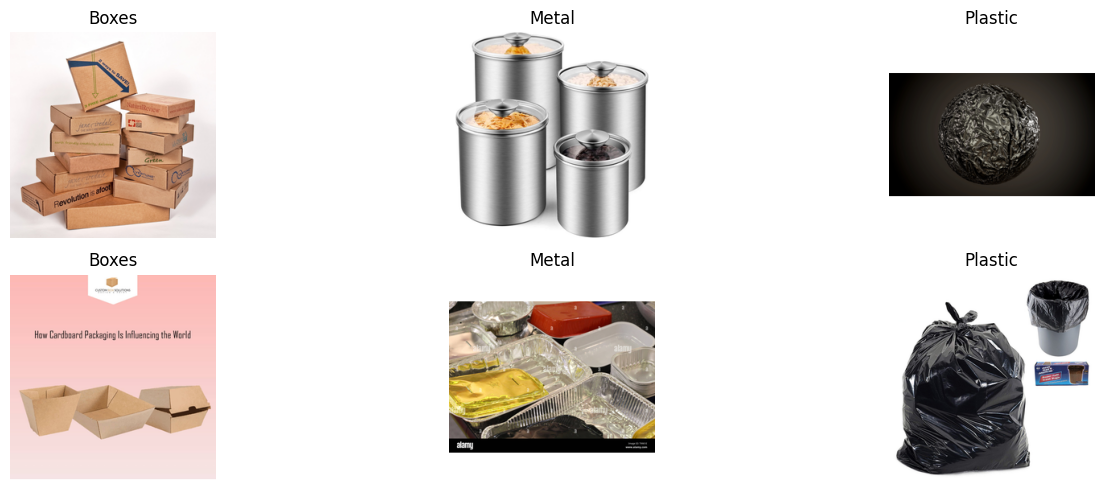


=== Preprocessing Images ===

Visualizing preprocessing steps...


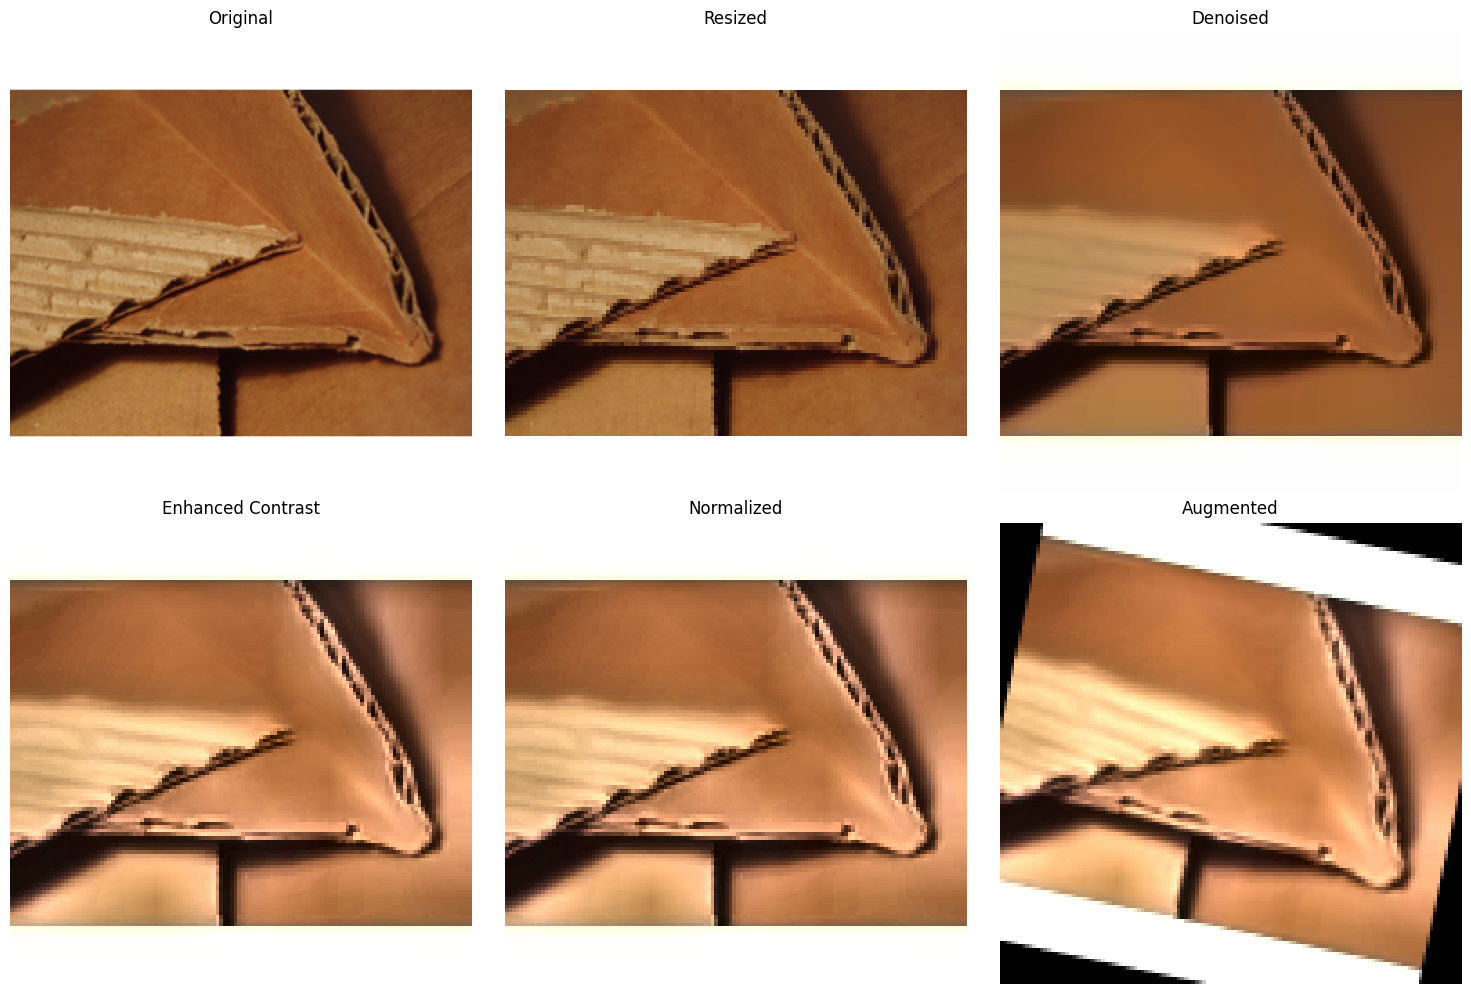


Preprocessing training images...
Processed 100/1050 images
Processed 200/1050 images
Processed 300/1050 images
Processed 400/1050 images
Processed 500/1050 images
Processed 600/1050 images
Processed 700/1050 images
Processed 800/1050 images
Processed 900/1050 images
Processed 1000/1050 images

Preprocessing test images...
Processed 50/225 images
Processed 100/225 images
Processed 150/225 images
Processed 200/225 images
Preprocessed dataset shapes: Train (1050, 128, 128, 3), Test (225, 128, 128, 3)

=== Applying Segmentation ===

Visualizing segmentation methods...


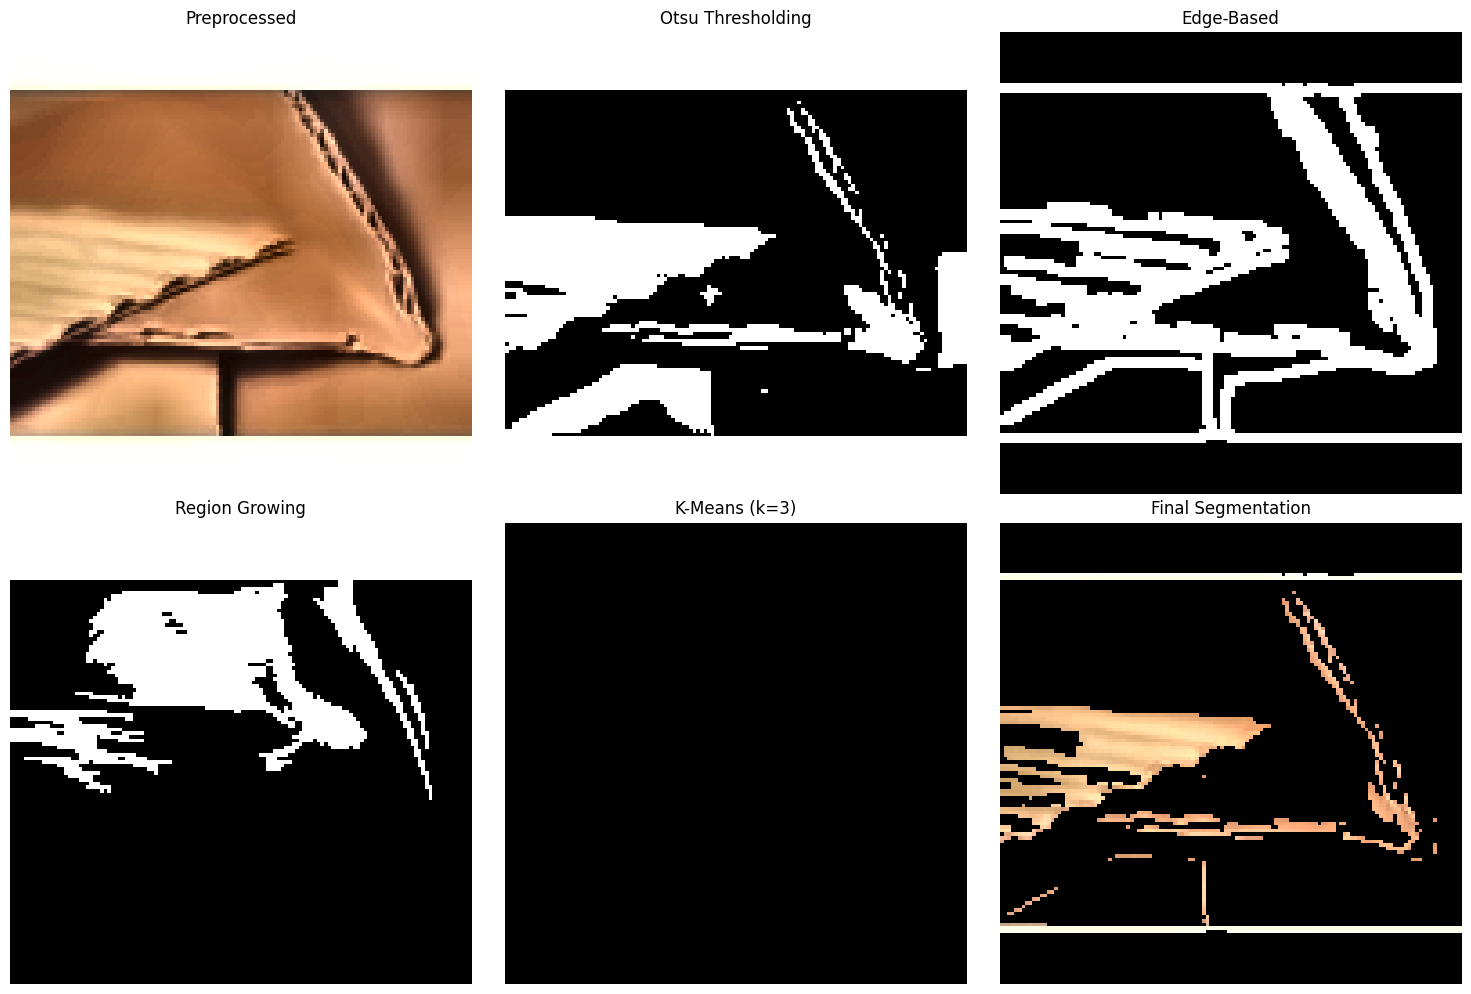


=== Extracting Enhanced Features ===

Visualizing enhanced feature extraction...


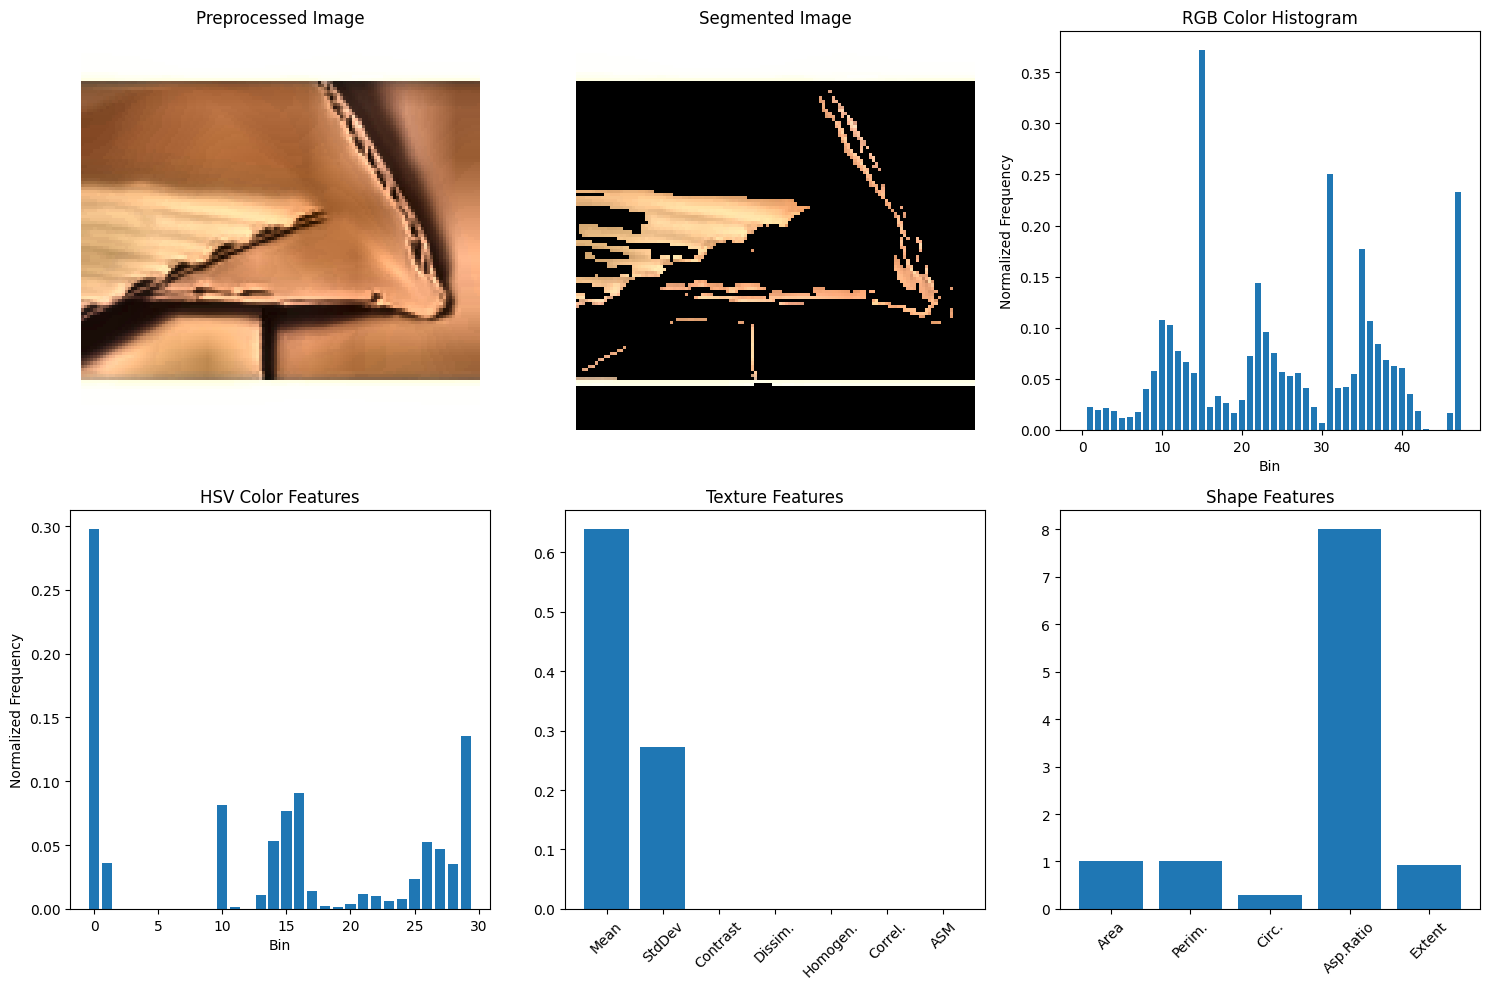


Extracting enhanced features from all images...
Extracted features from 20/1050 images
Extracted features from 40/1050 images
Extracted features from 60/1050 images
Extracted features from 80/1050 images
Extracted features from 100/1050 images
Extracted features from 120/1050 images
Extracted features from 140/1050 images
Extracted features from 160/1050 images
Extracted features from 180/1050 images
Extracted features from 200/1050 images
Extracted features from 220/1050 images
Extracted features from 240/1050 images
Extracted features from 260/1050 images
Extracted features from 280/1050 images
Extracted features from 300/1050 images
Extracted features from 320/1050 images
Extracted features from 340/1050 images
Extracted features from 360/1050 images
Extracted features from 380/1050 images
Extracted features from 400/1050 images
Extracted features from 420/1050 images
Extracted features from 440/1050 images
Extracted features from 460/1050 images
Extracted features from 480/1050 im

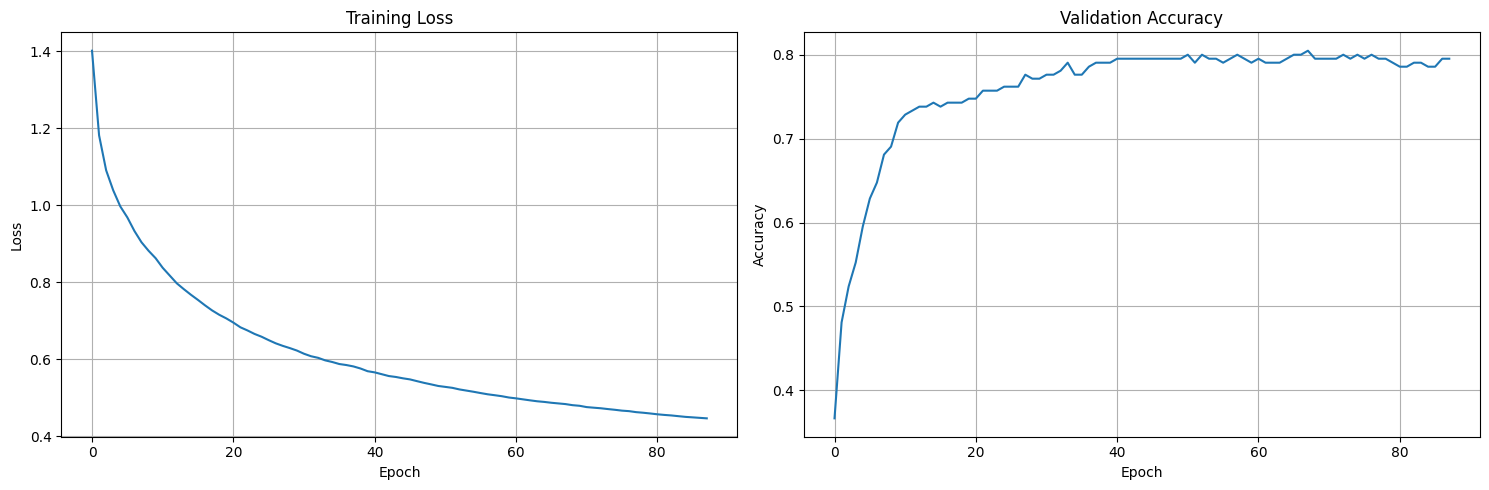


=== Evaluating Classifier ===
Classification Metrics:
Accuracy: 0.7600
Precision: 0.7613
Recall: 0.7600
F1-score: 0.7580


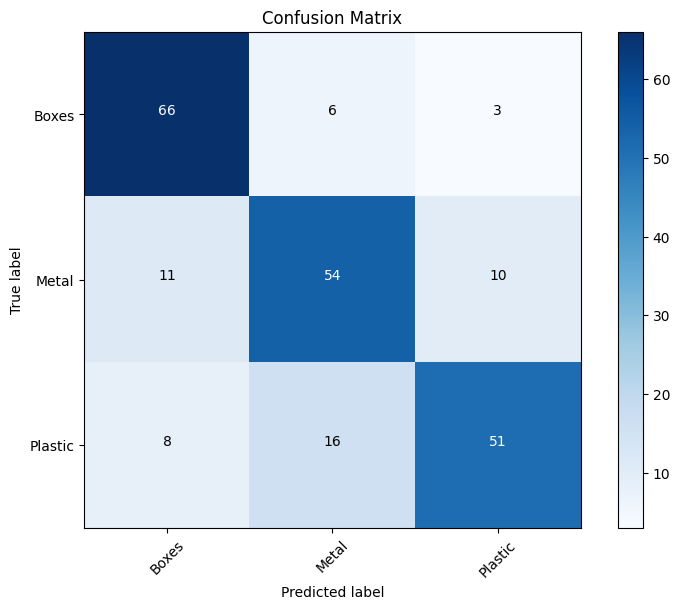


=== Saving Model ===
Model saved to 'models/recycled_materials_classifier.pkl'

=== Launching GUI ===
Close the GUI window to exit the program


In [13]:
def main():
    print("Starting Recycled Materials Classification Pipeline")
    
    print("\n=== Loading Dataset ===")
    (train_paths, train_labels), (test_paths, test_labels) = load_dataset()
    
    if not train_paths:
        print("Error: No training data found. Please check your dataset path.")
        return
    
    print("\nVisualizing sample images...")
    visualize_dataset_samples(train_paths, train_labels, num_samples=2)
    
    print("\n=== Preprocessing Images ===")
    if train_paths:
        print("\nVisualizing preprocessing steps...")
        visualize_preprocessing(train_paths[0])
    
    print("\nPreprocessing training images...")
    X_train_preprocessed = []
    for i, path in enumerate(train_paths):
        img, _ = preprocess_image(path)
        if not np.all(img == 0):
            X_train_preprocessed.append(img)
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{len(train_paths)} images")
    X_train_preprocessed = np.array(X_train_preprocessed)
    
    print("\nPreprocessing test images...")
    X_test_preprocessed = []
    for i, path in enumerate(test_paths):
        img, _ = preprocess_image(path)
        if not np.all(img == 0):
            X_test_preprocessed.append(img)
        if (i+1) % 50 == 0:
            print(f"Processed {i+1}/{len(test_paths)} images")
    X_test_preprocessed = np.array(X_test_preprocessed)
    
    print(f"Preprocessed dataset shapes: Train {X_train_preprocessed.shape}, Test {X_test_preprocessed.shape}")
    
    print("\n=== Applying Segmentation ===")
    if train_paths:
        print("\nVisualizing segmentation methods...")
        visualize_segmentation(train_paths[0])
    
    print("\n=== Extracting Enhanced Features ===")
    if train_paths:
        print("\nVisualizing enhanced feature extraction...")
        visualize_features(train_paths[0])
    
    print("\nExtracting enhanced features from all images...")
    X_train_features = []
    y_train = []
    for i, (img, label) in enumerate(zip(X_train_preprocessed, train_labels)):
        try:
            features, _, _ = extract_enhanced_features(img)
            if not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
                X_train_features.append(features)
                y_train.append(label)
            if (i+1) % 20 == 0:
                print(f"Extracted features from {i+1}/{len(X_train_preprocessed)} images")
        except Exception as e:
            print(f"Error extracting features from training image {i}: {e}")

    X_test_features = []
    y_test = []
    for i, (img, label) in enumerate(zip(X_test_preprocessed, test_labels)):
        try:
            features, _, _ = extract_enhanced_features(img)
            if not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
                X_test_features.append(features)
                y_test.append(label)
            if (i+1) % 20 == 0:
                print(f"Extracted features from {i+1}/{len(X_test_preprocessed)} images")
        except Exception as e:
            print(f"Error extracting features from test image {i}: {e}")

    X_train_features = np.array(X_train_features)
    X_test_features = np.array(X_test_features)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    print(f"Extracted features shapes: Train {X_train_features.shape}, Test {X_test_features.shape}")
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_features, y_train, test_size=0.2, random_state=42)
    
    print("\n=== Training Improved Classifier ===")
    classifier, val_accuracy = train_classifier(X_train, y_train, X_val, y_val, use_cnn=False)
    
    print("\n=== Evaluating Classifier ===")
    accuracy, precision, recall, f1, cm = evaluate_classifier(classifier, X_test_features, y_test)
    
    print("\n=== Saving Model ===")
    os.makedirs('models', exist_ok=True)
    with open('models/recycled_materials_classifier.pkl', 'wb') as f:
        pickle.dump(classifier, f)
    
    print("Model saved to 'models/recycled_materials_classifier.pkl'")
    
    print("\n=== Launching GUI ===")
    print("Close the GUI window to exit the program")
    
    root = tk.Tk()
    app = RecycledMaterialsClassifierGUI(root, classifier)
    root.mainloop()

if __name__ == "__main__":
    np.random.seed(42)
    random.seed(42)
    
    try:
        main()
    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()


## Launch GUI

In [ ]:
def launch_gui(model_path='models/recycled_materials_classifier.pkl'):
    try:
        print(f"Loading model from {model_path}...")
        with open(model_path, 'rb') as f:
            classifier = pickle.load(f)
        
        print("Initializing GUI...")
        root = tk.Tk()
        app = RecycledMaterialsClassifierGUI(root, classifier)
        
        print("GUI ready! Close the window to exit.")
        root.mainloop()
        
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        print("Please run the training pipeline first or specify the correct model path.")
    except Exception as e:
        print(f"Error launching GUI: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
launch_gui()